# Two-Level Model with Sequential Observations

by Noah Giles

## Table of contents

- [Two Level Priors](#toc1_1_)    
- [Two Level Model](#toc1_2_)    
  - [Simulated Local Walks](#toc1_2_1_)    
- [Networks and Amortizer](#toc1_3_)    
  - [Summary Network](#toc1_3_1_)    
  - [Amortizers](#toc1_3_2_)    
- [Training](#toc1_4_)    
- [Validation](#toc1_5_)    
  - [Latent Dims](#toc1_5_1_)    
  - [Checking Calibration](#calibration)
  - [Parameter Recovery in Example Dataset](#toc1_5_2_)    
  - [Recoveries in the Aggregate](#toc1_5_3_)    

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import bayesflow as bf
import tensorflow as tf

2025-01-27 20:15:19.441826: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-27 20:15:19.459100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-27 20:15:19.459121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-27 20:15:19.459673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 20:15:19.463223: I tensorflow/core/platform/cpu_feature_guar

This notebook demonstrates the components required for performing Bayesian inference in a two-level hierarchical model, focusing on cases where group-level observations are ordered and thus non-exchangeable. As a contrived example, we use a model that consists of multiple random walks, each governed by a shared population distribution.

$$
\begin{align*}
    \mu_{\text{pop}} &\sim \mathcal{N}(0, 1) && \text{(Population mean)} \\
    \mu_i &\sim \mathcal{N}(\mu_{\text{pop}}, \sigma=0.25) && \text{(Subgroup mean for group } i\text{)} \\
    x_{i,t} &\sim \mathcal{N}(x_{i,t-1} + \mu_i, 1) && \text{(Random walk with subgroup mean)}
\end{align*}
$$

The goal is thus to infer the posterior distributions of $\mu_i$ and $\mu_{\text{pop}}$ from observations $x_{i,t}$.

## <a id='toc1_1_'></a>Two Level Priors

The structure of our prior functions follows the hierarchical nature of the model. First, we define a hyper-prior function `hyper_prior_fun`, which samples population-level parameters. Then, a local prior function is specified, which takes these hyperparameters as inputs. To encode this into the framework, these functions are provided to a `TwoLevelPrior` object, in contrast to single-level models. Note that here, the local prior function returns parameters in an array of shape `(n_groups, n_params)`.

Also note that, if applicable, parameters shared across subgroups can additionally be implemented via a "shared prior" function, which can be provided as a third argument to the prior object.

In [2]:
N_TIMSTEPS = 40
N_GROUPS = 6

np.random.seed(42)

def hyper_prior_fun():
    return np.r_[np.random.normal(loc=0, scale=1)].astype(np.float32)


def local_prior_fun(hyper_params):
    mu_0 = hyper_params
    mu = np.random.normal(loc=mu_0, scale=0.25, size=(N_GROUPS, 1)).astype(np.float32)
    return mu


prior = bf.simulation.TwoLevelPrior(
    local_prior_fun=local_prior_fun, hyper_prior_fun=hyper_prior_fun
)
prior(batch_size=2)

{'hyper_parameters': array([[0.49671414],
        [0.7674347 ]], dtype=float32),
 'local_parameters': array([[[0.46214807],
         [0.6586363 ],
         [0.8774716 ],
         [0.4381758 ],
         [0.4381799 ],
         [0.89151734]],
 
        [[0.65006614],
         [0.90307474],
         [0.6515803 ],
         [0.6510023 ],
         [0.82792526],
         [0.28911465]]], dtype=float32),
 'batchable_context': None,
 'non_batchable_context': None}

## <a id='toc1_2_'></a>Two Level Model

In similar fashion to the definition of our prior, here we make use of the dedicated `TwoLevelGenerativeModel` class for the purposes of implementing our simulation. Since this simulation function is not batched, we receive params in the shape `(n_groups, n_params)`, and return data in the shape `(n_groups, n_observations, n_dims)`. 

In [3]:
def simulate(params, context=None, **kwargs):
    mu = params
    mu = np.broadcast_to(mu, shape=(N_GROUPS, N_TIMSTEPS))
    return (
        np.random.normal(loc=mu, scale=1.0)
        .cumsum(axis=1)
        .reshape((N_GROUPS, N_TIMSTEPS, 1))
    )


model = bf.simulation.TwoLevelGenerativeModel(
    prior, simulator=simulate, simulator_is_batched=False
)
model(1)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 6, 40, 1)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 6, 1)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


{'sim_data': array([[[[  0.59617533],
          [  0.93787662],
          [ -0.19889452],
          [ -0.25877812],
          [  0.33339311],
          [ -1.49522807],
          [ -1.11108377],
          [ -1.93292343],
          [ -1.52154066],
          [ -2.44401571],
          [ -4.40811371],
          [ -6.19487204],
          [ -6.306003  ],
          [ -6.20549639],
          [ -7.26902891],
          [ -6.78965235],
          [ -8.61038831],
          [ -8.83568401],
          [-10.2059161 ],
          [-11.01696811],
          [-11.12878534],
          [-12.1484146 ],
          [-12.69218604],
          [-11.84510913],
          [-12.58121689],
          [-11.90474068],
          [-13.19366343],
          [-12.82307515],
          [-11.54072243],
          [-14.17158283],
          [-15.12769398],
          [-14.70983775],
          [-15.07209903],
          [-14.86016906],
          [-15.62337014],
          [-15.69599625],
          [-16.01088938],
          [-15.00232322],


### <a id='toc1_2_1_'></a>Simulated Local Walks

Having defined our simulator function, below is an example of one of our generated datasets, which we will save for subsequent use.

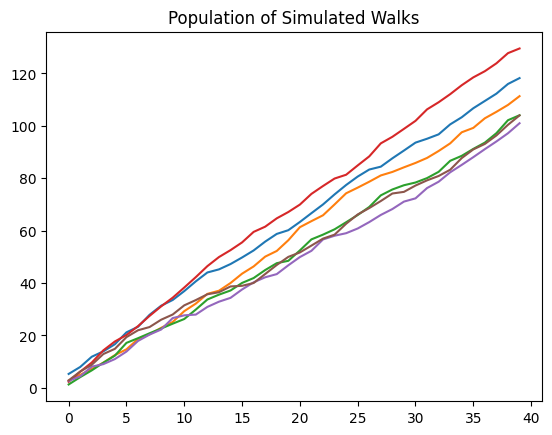

In [4]:
test_sim = model(1)
for g in range(N_GROUPS):
    sim_data = test_sim["sim_data"][0, g, :].reshape((-1))
    plt.plot(np.arange(0, N_TIMSTEPS), sim_data, alpha=1)
plt.title("Population of Simulated Walks")
plt.show()

## <a id='toc1_3_'></a>Networks and Amortizer

### <a id='toc1_3_1_'></a>Summary Network

Since our data follows a hierarchical structure, summaries must be aggregated "up" the hierarchy. We first define a local summary network, which processes individual subgroups, and then a population-level summary network, which consolidates these local summaries to characterize the overall population.

Because the observations within our local groups are ordered, we use a `SequenceNetwork` to ensure that the model respects the sequential nature of the data. Note that because the `SequenceNetwork` expects inputs of shape `(n_batches, n_observations, n_dims)`, we [must wrap it](https://discuss.bayesflow.org/t/time-series-dimension-errors-in-hierarchicalnetwork/122/2) in a `TimeDistributed` layer so that it can correctly process our data, which will have shape `(n_batches, n_groups, n_observations, n_dims)`. 

At the population level, subgroup summaries are permutation-invariant, allowing us to use a `DeepSet` for aggregation. Both summary networks are encapsulated within a HierarchicalNetwork, which automatically applies the appropriate network at each hierarchical level—starting with the lowest-level observations and propagating upwards.

In [5]:
seq_net = tf.keras.layers.TimeDistributed(bf.networks.SequenceNetwork(summary_dim=32))
seq_net.build((None, None, None, 1))
summary_net = bf.summary_networks.HierarchicalNetwork(
    [seq_net, bf.summary_networks.DeepSet(summary_dim=128)]
)

2025-01-27 20:15:20.430925: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-27 20:15:20.443491: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-27 20:15:20.445082: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### <a id='toc1_3_2_'></a>Amortizers

The amortization process follows the hierarchical structure of our model, mirroring the construction of the summary networks. We define a local amortizer, which is responsible for approximating the posterior of local parameters within subgroups, and a global amortizer which learns the posterior of global (i.e., hyper- and shared) parameters. These are in turn wrapped into a `TwoLevelAmortizedPosterior` which knows how to interface with hierarchical data. 

In [6]:
local_amortizer = bf.amortizers.AmortizedPosterior(
    inference_net=bf.networks.InvertibleNetwork(num_params=1)
)
global_amortizer = bf.amortizers.AmortizedPosterior(
    inference_net=bf.networks.InvertibleNetwork(
        num_params=1,
    )
)
amortizer = bf.amortizers.TwoLevelAmortizedPosterior(
    local_amortizer=local_amortizer,
    global_amortizer=global_amortizer,
    summary_net=summary_net,
)

## <a id='toc1_4_'></a>Training

When defining the configurator function, we must correctly handle both hyperparameters (global-level) and local parameters (subgroup-level). In this case, no special scaling or transformations are required, so they can be passed through directly. With these considerations in place, the training process proceeds straightforwardly.

In [7]:
def configure_inputs(forward_dict):
    out_dict = {}

    out_dict["hyper_parameters"] = forward_dict["hyper_prior_draws"]
    out_dict["local_parameters"] = forward_dict["local_prior_draws"]

    out_dict["sim_data"] = forward_dict["sim_data"]
    out_dict["summary_conditions"] = (
        forward_dict["sim_data"] / 100
    )  # back-of-the hand scaling for observations

    return out_dict

In [8]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer, generative_model=model, configurator=configure_inputs
)

INFO:root:Performing a consistency check with provided components...
2025-01-27 20:15:21.210310: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-01-27 20:15:21.241837: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
INFO:root:Done.


In [9]:
history = trainer.train_online(
    epochs=12,
    iterations_per_epoch=1000,
    batch_size=32,
    validation_sims=200,
)

INFO:root:Generated 200 simulations for validation.


Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-01-27 20:15:34.869468: I external/local_xla/xla/service/service.cc:168] XLA service 0x7319d08ea000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-27 20:15:34.869487: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-01-27 20:15:34.872044: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738026934.920236   23012 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
INFO:root:Validation, Epoch: 1, Local.Loss: -0.575, Global.Loss: -0.594


Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Local.Loss: -0.582, Global.Loss: -0.640


Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Local.Loss: -0.612, Global.Loss: -0.710


Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Local.Loss: -0.613, Global.Loss: -0.717


Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Local.Loss: -0.611, Global.Loss: -0.683


Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Local.Loss: -0.618, Global.Loss: -0.717


Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Local.Loss: -0.616, Global.Loss: -0.712


Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Local.Loss: -0.622, Global.Loss: -0.741


Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Local.Loss: -0.619, Global.Loss: -0.752


Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Local.Loss: -0.620, Global.Loss: -0.731


Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Local.Loss: -0.619, Global.Loss: -0.745


Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Local.Loss: -0.621, Global.Loss: -0.753


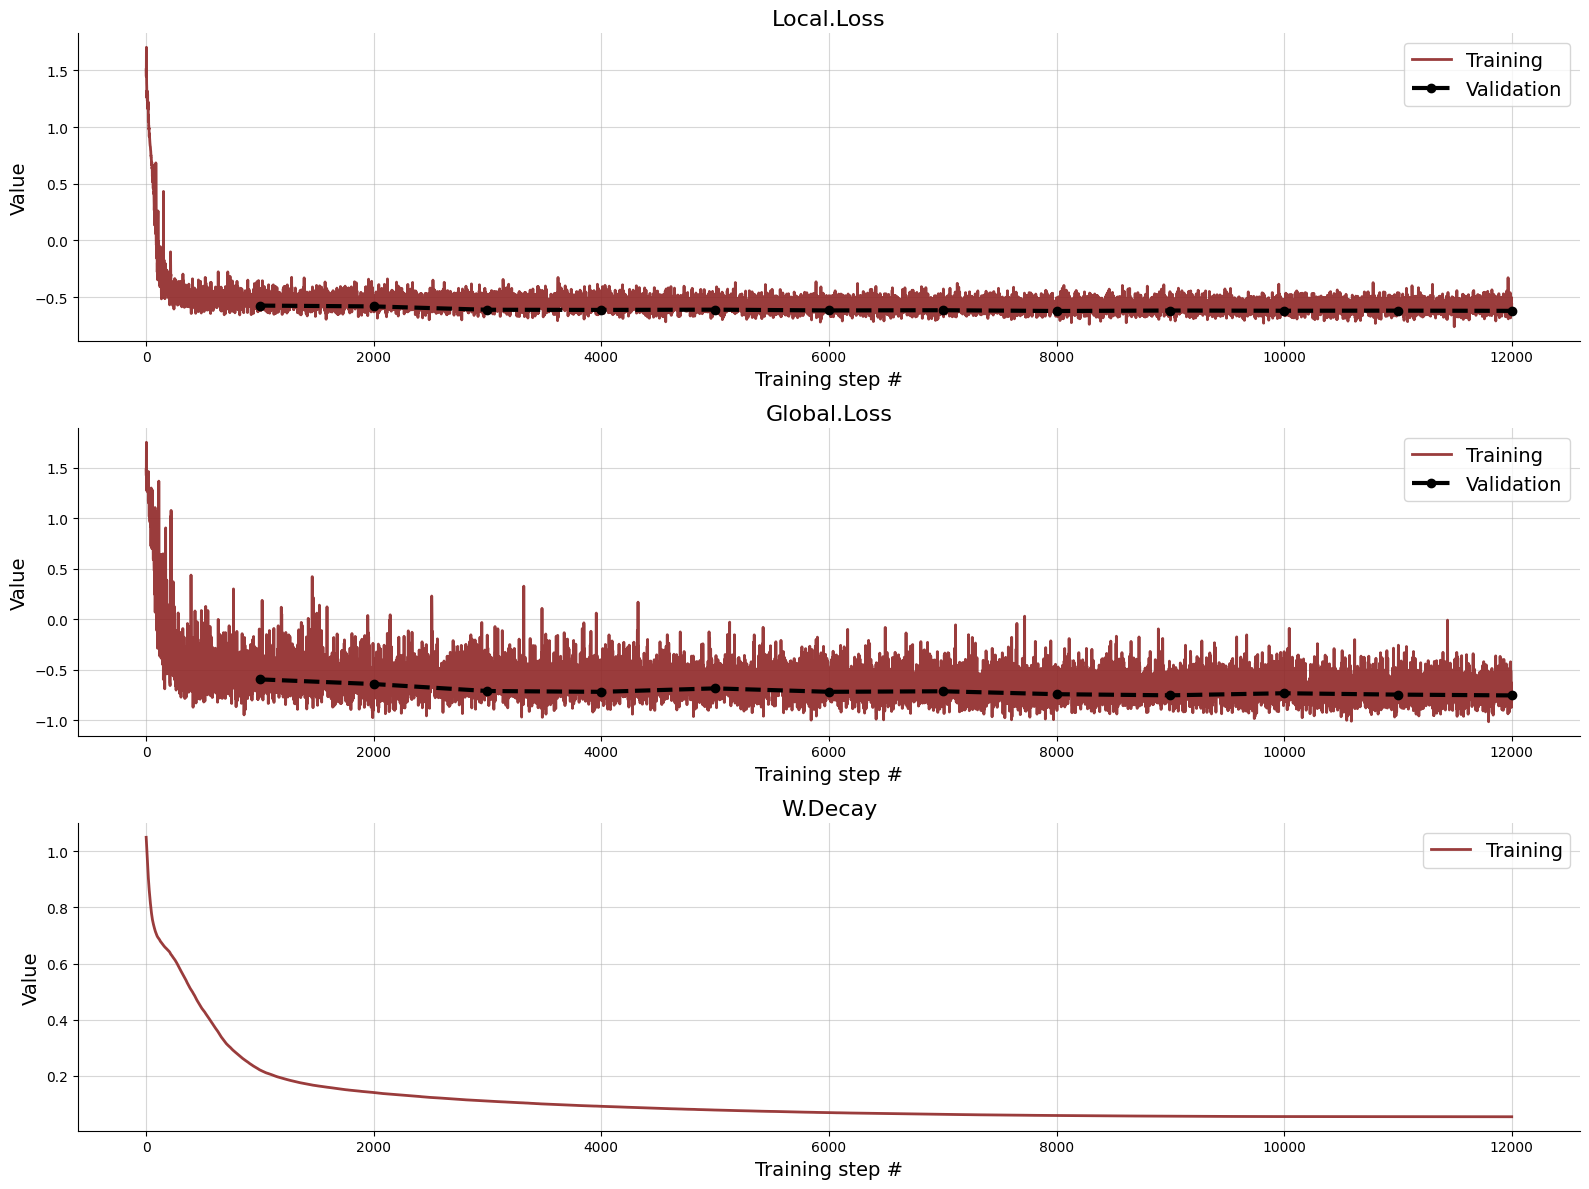

In [10]:
f = bf.diagnostics.plot_losses(
    history["train_losses"], history["val_losses"], moving_average=True
)

## <a id='toc1_5_'></a>Validation

### <a id='toc1_5_1_'></a>Latent Dims
Having fit the nets, we can now check the quality of the fit. Since our amortizer operates on two levels, it returns two sets of samples from the latent space. We can inspect both of them to ensure that the latent dimensions follow the prescribed Gaussian structure.

In [11]:
test_sims = trainer.configurator(model(500))
(z_samples_local, log_det_j_local), (z_samples_global, log_det_j_global) = amortizer(
    test_sims
)

The latent dims in on the global level:

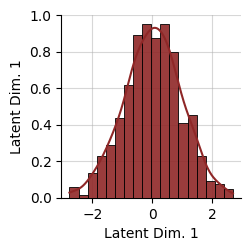

In [12]:
f = bf.diagnostics.plot_latent_space_2d(z_samples_global)

Latent dims at the local level:

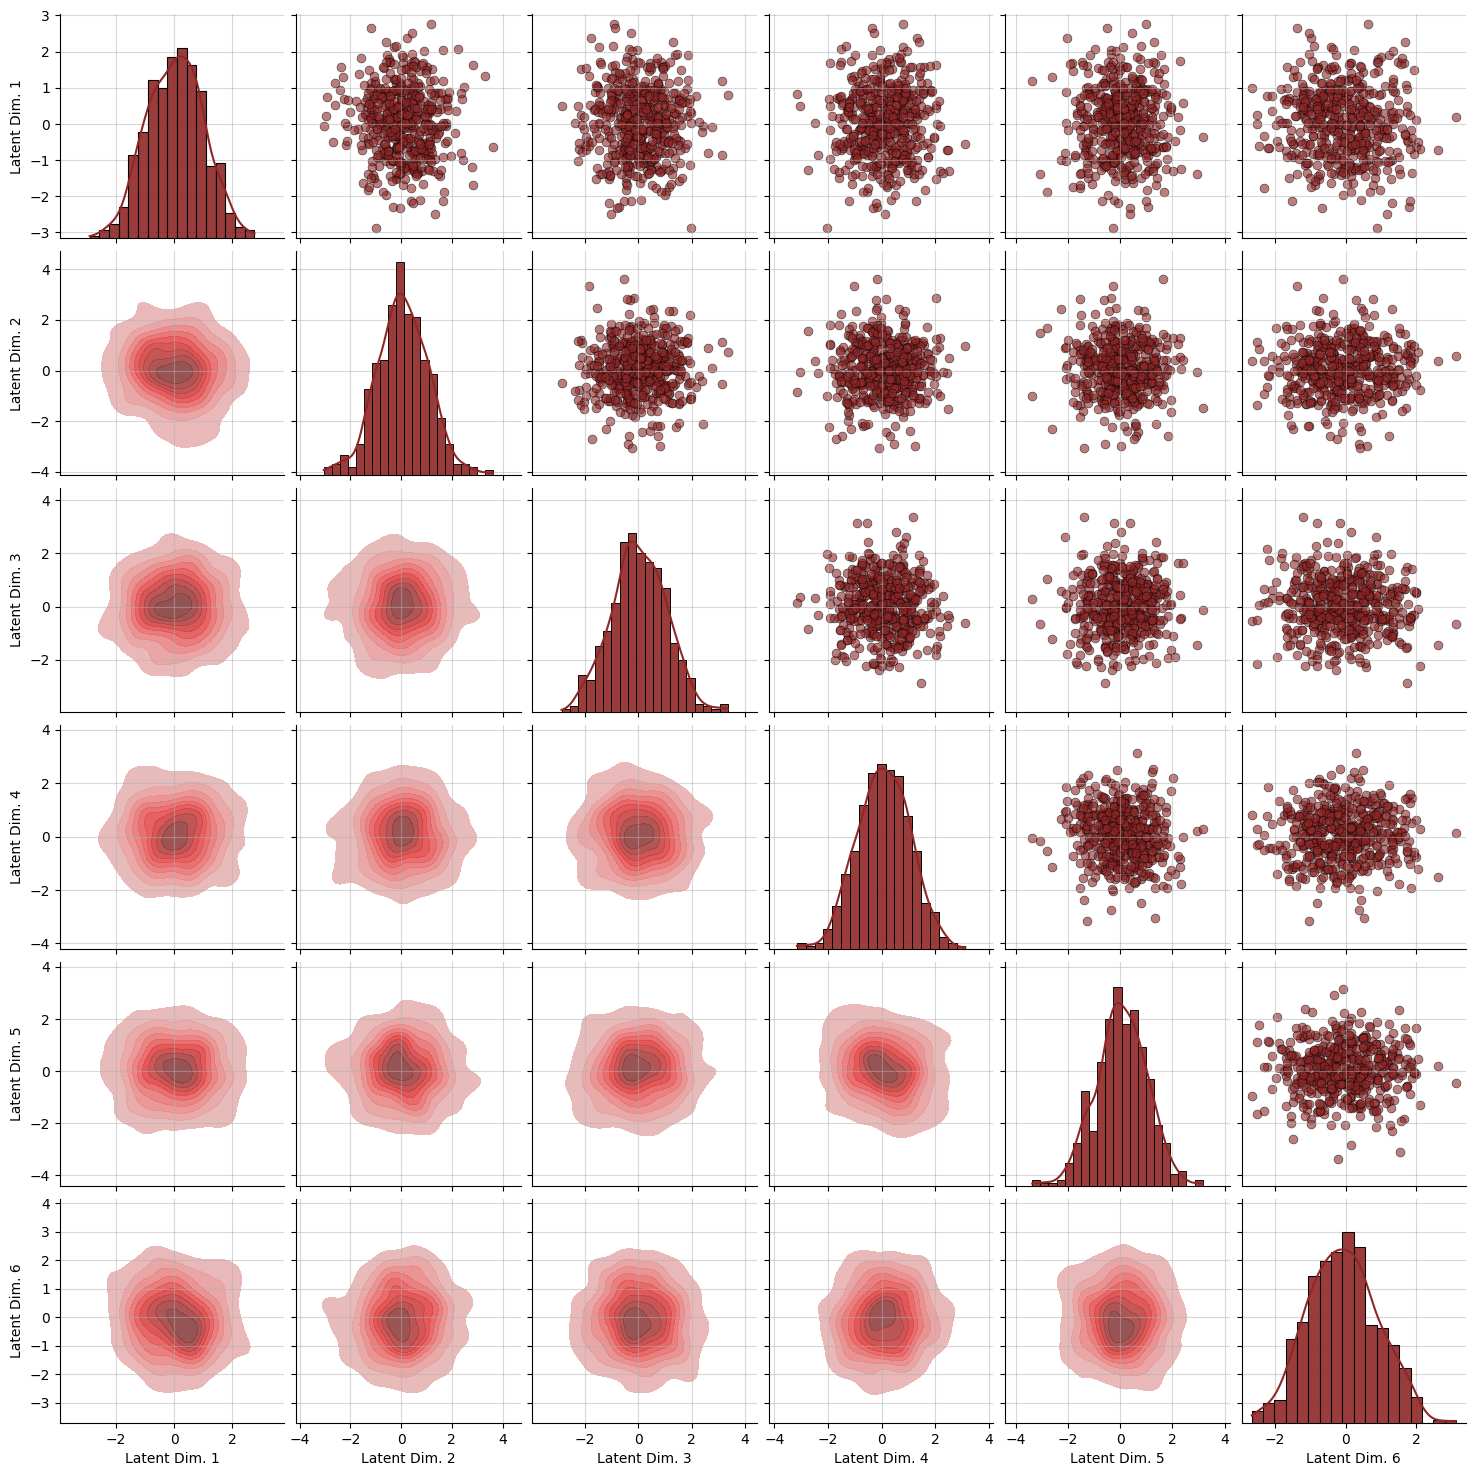

In [13]:
f = bf.diagnostics.plot_latent_space_2d(np.squeeze(z_samples_local.numpy()))

### <a id='calibration'></a>Checking Calibration

In [14]:
global_samples = []
local_samples = []
for i in range(test_sims["hyper_parameters"].shape[0]):
    sim = {k: v[i][np.newaxis, ...] for k, v in test_sims.items()}
    posterior = amortizer.sample(sim, n_samples=100)
    global_samples.append(posterior["global_samples"])
    local_samples.append(posterior["local_samples"])

We can check the reliability of the model via rank statistics histograms at the global and local levels (see: https://arxiv.org/abs/1804.06788):

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 5.                    Confidence intervals might be unreliable!


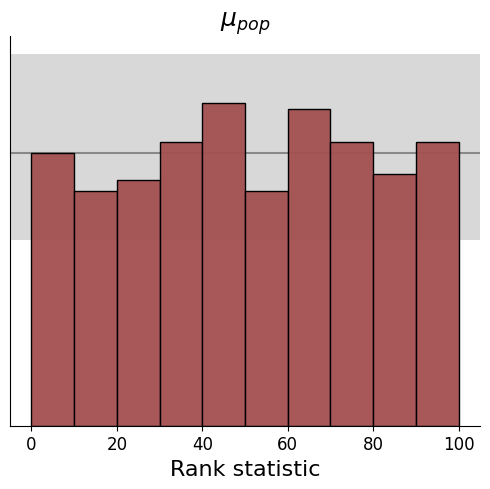

In [15]:
f = bf.diagnostics.plot_sbc_histograms(
    np.stack(global_samples), test_sims["hyper_parameters"], num_bins=10, param_names=["$\mu_{pop}$"]
)

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 5.                    Confidence intervals might be unreliable!


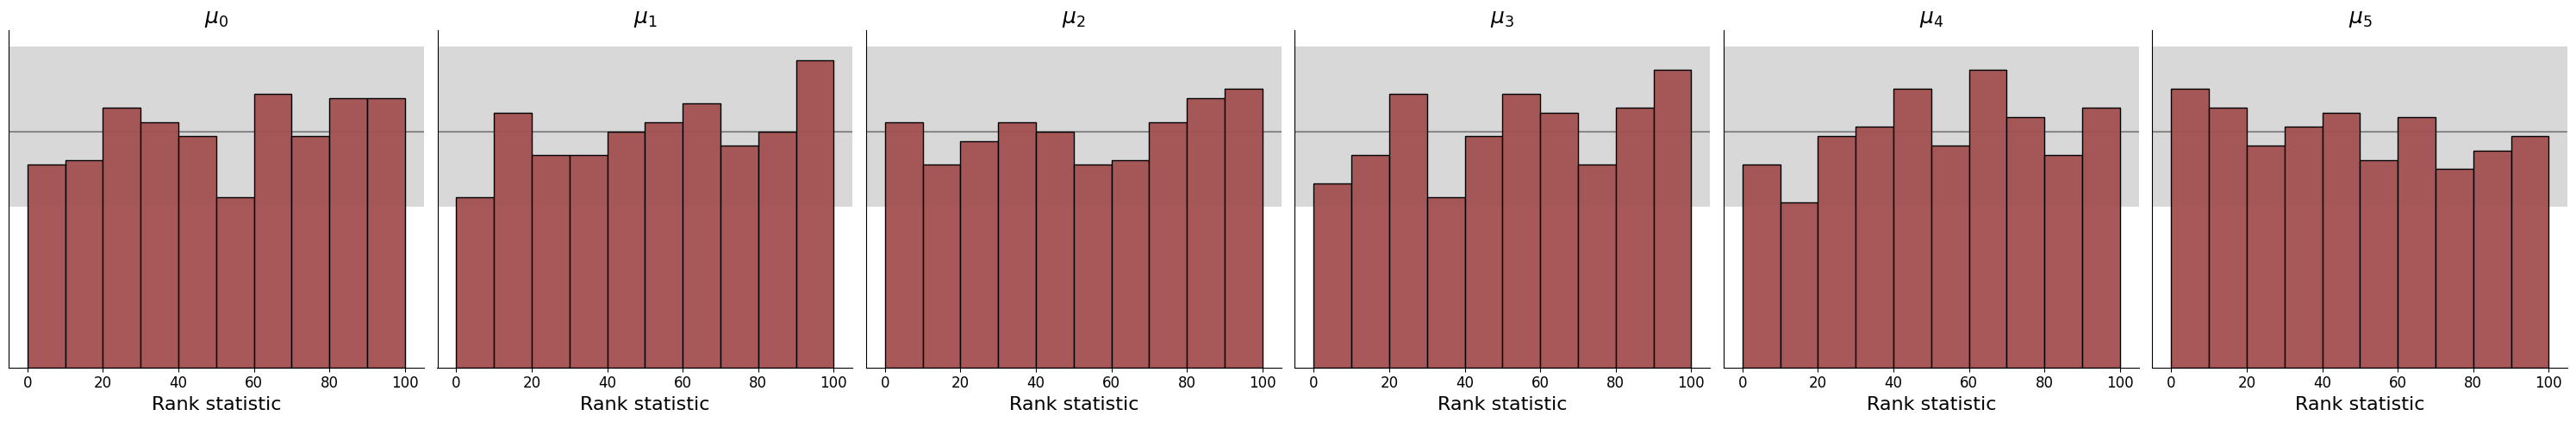

In [16]:
f = bf.diagnostics.plot_sbc_histograms(
    np.concatenate(local_samples, axis=2).T,
    test_sims["local_parameters"].squeeze(),
    num_bins=10,
    param_names=[f"$\mu_{i}$" for i in range(N_GROUPS)],
)

Alternatively, we can check calibration via the Empirical CDF (see: https://arxiv.org/abs/2103.10522):

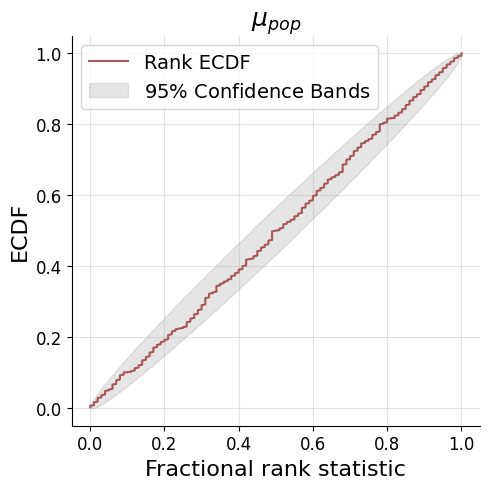

In [17]:
f = bf.diagnostics.plot_sbc_ecdf(np.stack(global_samples), test_sims["hyper_parameters"], param_names=["$\mu_{pop}$"])

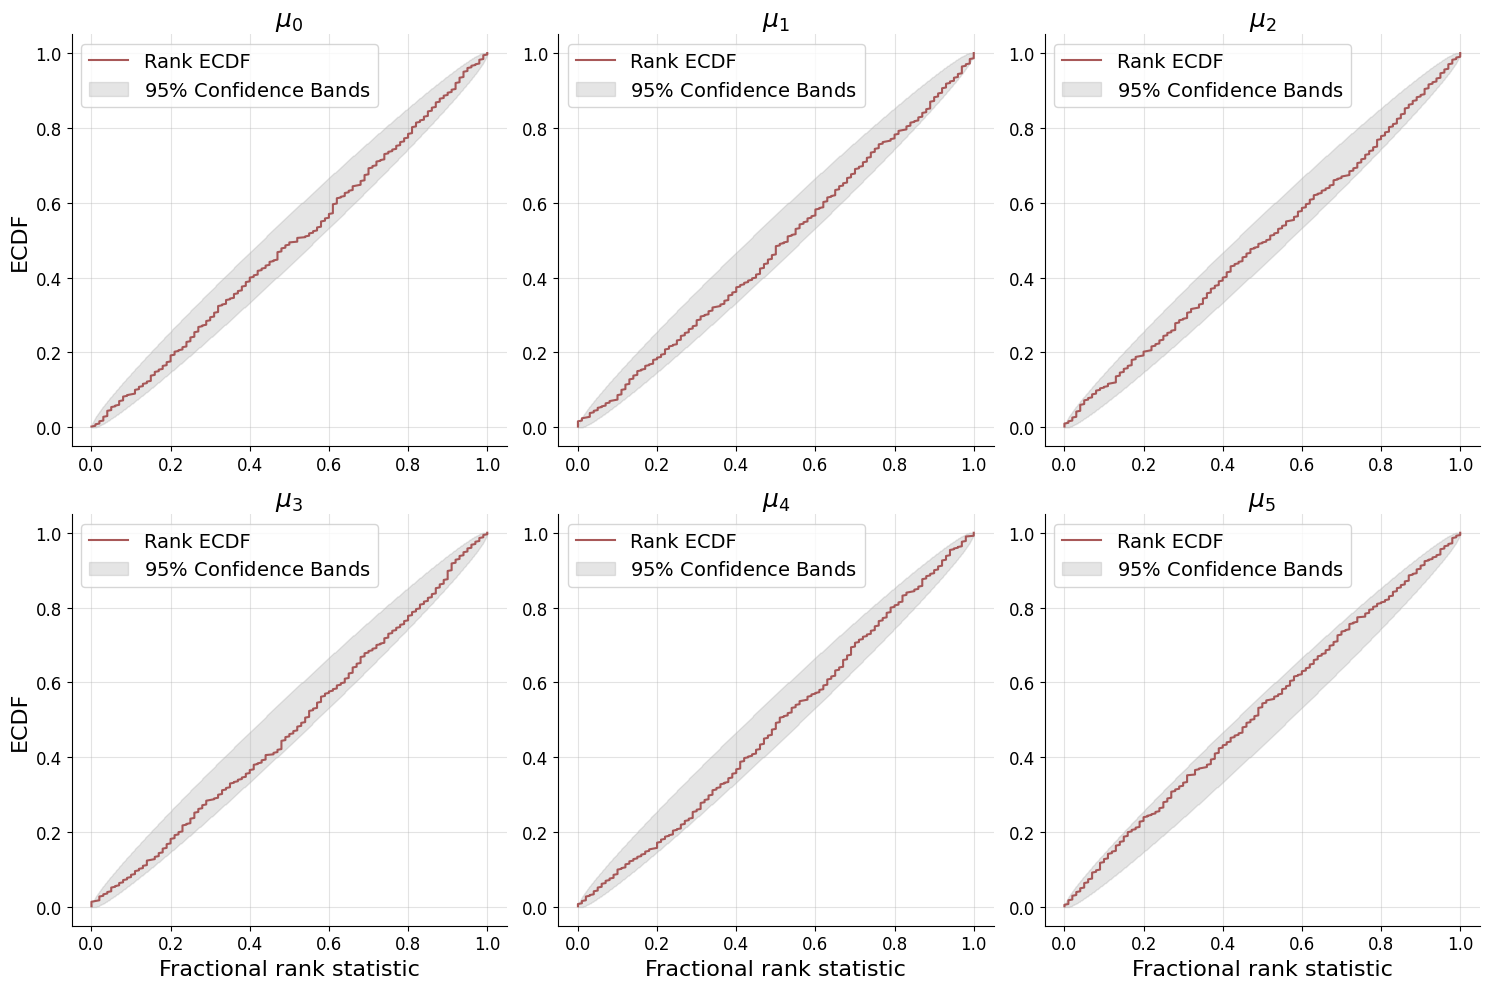

In [18]:
f = bf.diagnostics.plot_sbc_ecdf(
    np.concatenate(local_samples, axis=2).T,
    test_sims["local_parameters"].squeeze(),
    param_names=[f"$\mu_{i}$" for i in range(N_GROUPS)],
    n_row=2,
    n_col=3,
)

### <a id='toc1_5_2_'></a>Parameter Recovery in Example Dataset

We can additionally check how well the model recovered the parameters of our initial example dataset.

In [19]:
N_POSTERIOR_SAMPLES = 4_000

posterior_samples = amortizer.sample(
    trainer.configurator(test_sim), N_POSTERIOR_SAMPLES
)

At a global level:

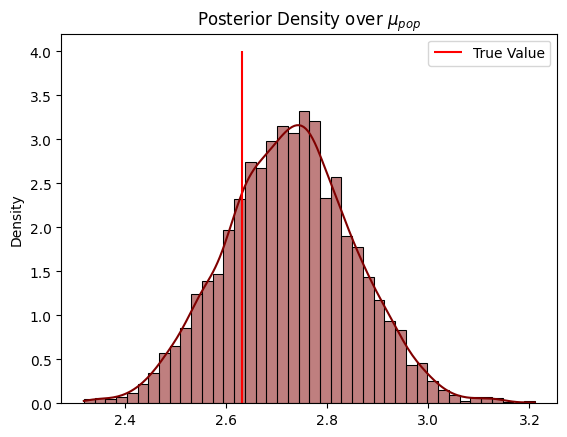

In [20]:
sns.histplot(
    posterior_samples["global_samples"].reshape((-1)),
    kde=True,
    color="maroon",
    stat="density",
)
plt.vlines(
    test_sim["hyper_prior_draws"][0], ymin=0, ymax=4, color="r", label="True Value"
)
plt.legend()
plt.title("Posterior Density over $\mu_{{pop}}$")
plt.show()

At the local level:

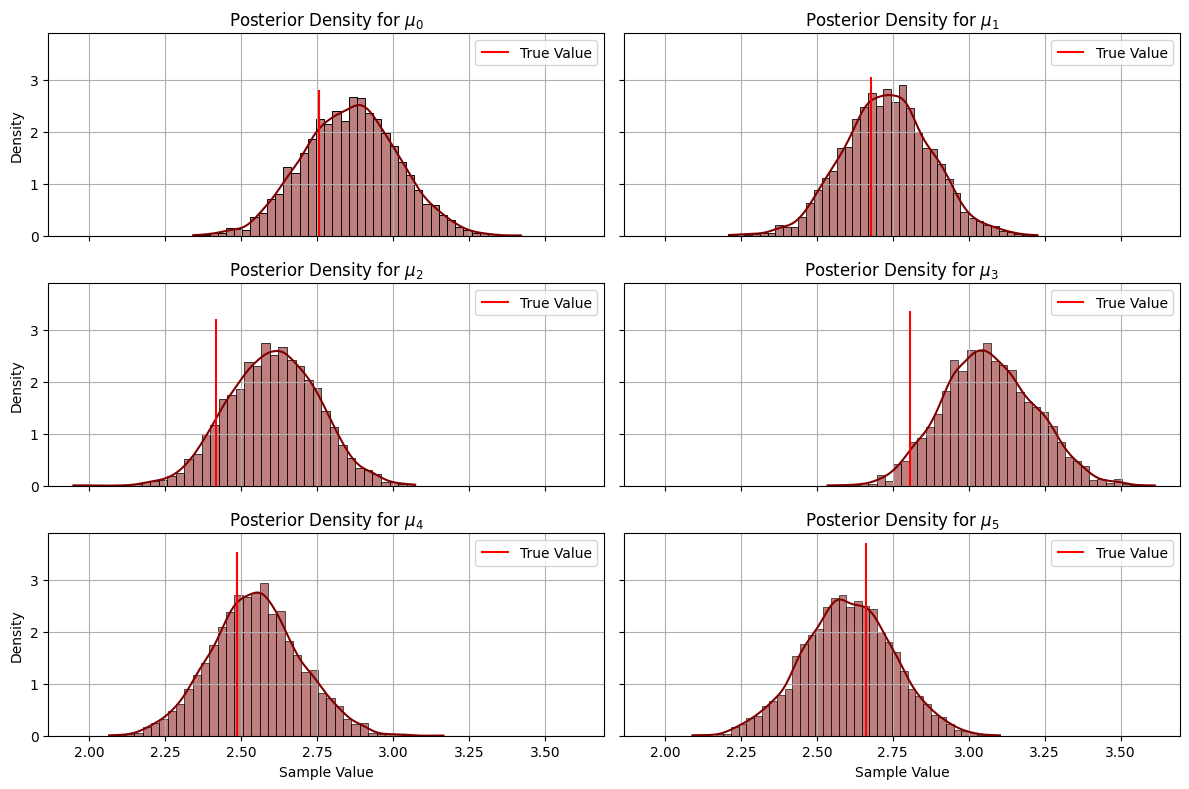

In [21]:
num_plots = 6
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]

    sns.histplot(
        posterior_samples["local_samples"][i].reshape((-1)),
        bins=40,
        kde=True,
        color="maroon",
        stat="density",
        ax=ax,
    )

    ax.vlines(
        test_sim["local_prior_draws"][0, i],
        ymin=0,
        ymax=ax.get_ylim()[1],
        color="r",
        label="True Value",
    )

    ax.set_title(f"Posterior Density for $\mu_{i}$")
    ax.set_xlabel("Sample Value")
    ax.set_ylabel("Density")
    ax.legend()

    ax.grid(True)

plt.tight_layout()
plt.show()

### <a id='toc1_5_3_'></a> Recoveries in the Aggregate

Here we check how well the model recovers parameters over a large population of simulated datasets.

In [22]:
N_EVAL_SIMS = 100
N_EVAL_POSTERIOR_SAMPLES = 2_000

eval_local_params = []
eval_local_posterior_samples = []

eval_global_params = []
eval_global_posterior_samples = []

for i in range(N_EVAL_SIMS):
    eval_sim = trainer.configurator(model(1))
    eval_posterior_samples = amortizer.sample(eval_sim, N_EVAL_POSTERIOR_SAMPLES)

    eval_local_params.append(eval_sim["local_parameters"][0])
    eval_local_posterior_samples.append(
        np.squeeze(eval_posterior_samples["local_samples"]).T
    )

    eval_global_params.append(eval_sim["hyper_parameters"][0])
    eval_global_posterior_samples.append(eval_posterior_samples["global_samples"])

eval_local_params = np.squeeze(np.stack(eval_local_params))
eval_local_posterior_samples = np.stack(eval_local_posterior_samples)

eval_global_params = np.stack(eval_global_params)
eval_global_posterior_samples = np.stack(eval_global_posterior_samples)

Recovery at the population level:

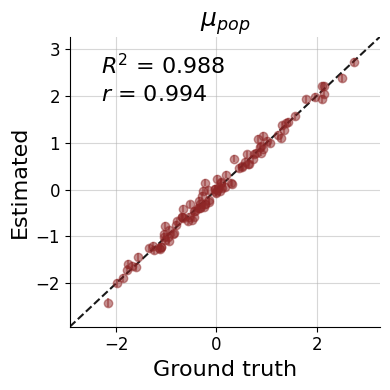

In [23]:
f = bf.diagnostics.plot_recovery(
    eval_global_posterior_samples, eval_global_params, param_names=["$\mu_{pop}$"]
)

Recovery at the group level:

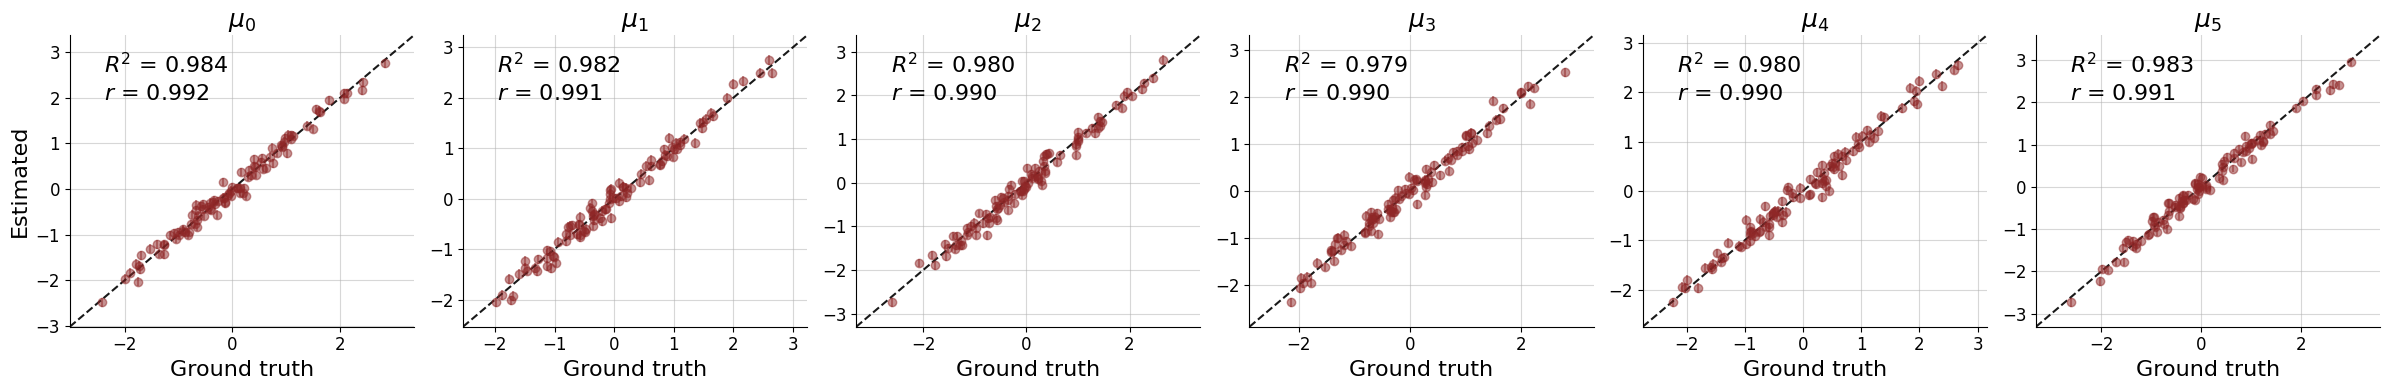

In [24]:
f = bf.diagnostics.plot_recovery(
    eval_local_posterior_samples,
    np.squeeze(eval_local_params),
    param_names=[f"$\mu_{i}$" for i in range(N_GROUPS)],
)